In [1]:
import data_process
reload(data_process)
import research
reload(research)
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

In [11]:
target = 'ru0'
train_start, train_end, test_start, test_end = '20180206', ' 20180329', '20180330', '20180330'
period = '1s'
if period == '0s':
    lag = '500ms'
else:
    lag = period
resample = True
resample_period = '2s'

In [3]:
rese = research.Research(target=target)
train = research.Train(target = target)

In [4]:
tickerlst = rese.get_symbols()
print tickerlst

['rb0', 'hc0', 'ni0', 'zn0', 'cu0', 'j10', 'i10', 'jm0', 'MA0', 'pb0']


get most correlated symbols from mysql database according to appointed period and lag.

In [5]:
train_daylst = rese.generate_daylst(train_start, train_end)
test_daylst = rese.generate_daylst(test_start, test_end)

In [6]:
train_data = rese.load_data(tickerlst, daylst=train_daylst, lag=lag, period = period)
test_data = rese.load_data(tickerlst, daylst=test_daylst, lag=lag, period = period)

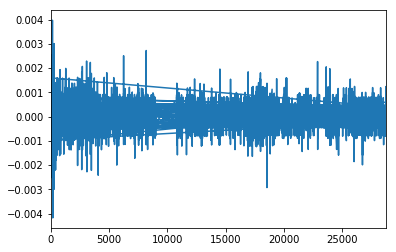

In [7]:
none_zero_flag = [True if val != 0 else False for val in train_data[target].values]
none_zero = train_data[none_zero_flag]
none_zero[target].plot()
plt.show()

std of train data is 0.000115


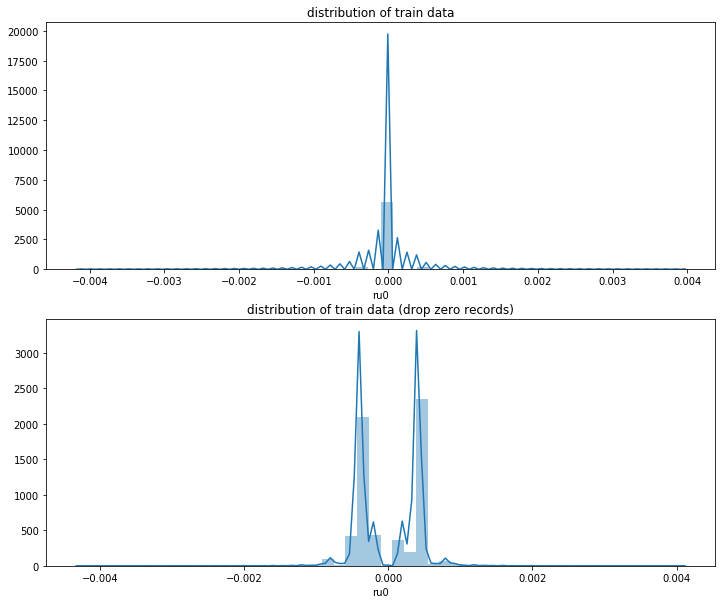

std of none-zero df is 0.000422


In [8]:
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.title('distribution of train data')
sns.distplot(train_data[target])
print 'std of train data is %f' %np.std(train_data[target].values)

plt.subplot(2,1,2)
sns.distplot(none_zero[target])
plt.title('distribution of train data (drop zero records)')
plt.show()
none_zero_std = np.std(none_zero[target])
print 'std of none-zero df is %f' %none_zero_std

           std of train data is 0.000115, mean of train data is -0.000000


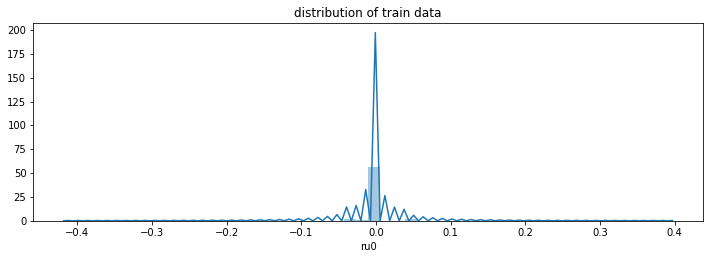

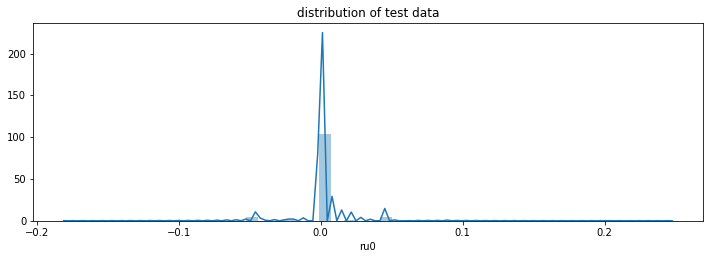

           std of test data is 0.000145, mean of train data is 0.000001


In [9]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.title('distribution of train data')
sns.distplot(train_data[target]*100)
print '           std of train data is %f, mean of train data is %f' %(np.std(train_data[target].values), np.mean(train_data[target].values))

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.title('distribution of test data')
sns.distplot(test_data[target]*100)
plt.show()
print '           std of test data is %f, mean of test data is %f' %(np.std(test_data[target].values),np.mean(test_data[target].values))

In [10]:
train_price = rese.load_price(train_daylst,lag)
test_price = rese.load_price(test_daylst, lag)

In [23]:
if resample:
    train_data = train.sample(resample_period=resample_period, df=train_data, keep_target_no_zero=False)
    test_data = train.sample(resample_period = resample_period, df=test_data, keep_target_no_zero=False)
    train_price = train.sample(resample_period=resample_period, df=train_price, keep_target_no_zero=False)
    test_price = train.sample(resample_period=resample_period, df=test_price, keep_target_no_zero=False)

本来是准备把大于3倍方差的去掉的，但是发现去了之后剩下的0值更多了
所以考虑以下做法：
    1.由于0值太多，所以分成多个数据集，每个数据集由数量相近的0值记录和非零值记录组成
    2.对于每个数据集，再查看大于3倍方差的，看有没有必要去掉

In [13]:
def easy_ensemble(data, clf, target=target,n_model='default', zero_no_zero_times = 2, cut_outlier=True):
    if n_model == 'default':
        count = 0  # 0记录的数量
        for val in data[target].values:
            if val == 0:
                count += 1
        l = data.shape[0]
        n_model = count / (l - count) / zero_no_zero_times  # 使得划分的模型数和0值、非0值比值是指定的比值，这样就能保证每个clf的数据里非0和0值差不多
    target_col = data[target].values
    zero_flag = [True if val == 0 else False for val in target_col]
    not_zero_flag = [True if val != 0 else False for val in target_col]
    zero_records = data[zero_flag]
    not_zero_records = data[not_zero_flag]
    if cut_outlier:  # 去掉非零值中的outliers
        mean = np.mean(not_zero_records.values)
        std = np.std(not_zero_records.values)
        flag=[]
        for val in not_zero_records[target].values:
            flag1, flag2 = False, False
            to_test_1, to_test_2 = mean+3*std,mean-3*std
            if val < to_test_1:
                flag1 = True
            if val > to_test_2:
                flag2 = True
            if flag1 and flag2:
                flag.append(True)
            else:
                flag.append(False)
        not_zero_records = not_zero_records[flag]
    zero_dic = df_split(zero_records, n=n_model)
    clf_dic, train_score = {}, {}
    for key in zero_dic.keys():
        this_df = pd.concat([not_zero_records, zero_dic[key]])
        this_df = shuffle(this_df)
        this_x, this_y = train.split_x_y(this_df)
        clf.fit(this_x, this_y)
        train_score[key] = clf.score(this_x, this_y)
        clf_dic[key] = clf
    return clf_dic, train_score
        
def df_split(data, n):
    '''split dataframe into n parts'''
    data = shuffle(data)
    l = data.shape[0]
    len_per_part = l/n
    dic = {}
    num=1
    start=0
    while num< n:
        end = start+len_per_part
        temp = data.iloc[start:end,:]
        dic[str(num)] = temp
        start=end
        num+=1
    dic[str(n)] = data.iloc[start:,:]
    return dic

def cut_outlier(data, target_col=target, thres=3):   # 去掉数值大于thres倍方差的
    df = data.copy()
    scaled = StandardScaler().fit_transform(df[target_col][:,np.newaxis])
    flag = [True if abs(val) <= thres else False for val in scaled]
    return data[flag]

In [14]:
from sklearn.linear_model import Ridge, RidgeCV
clf = RidgeCV(alphas=np.arange(0.01,1,0.01),normalize=True)
clf_dic , score_dic = easy_ensemble(train_data, clf)

In [15]:
def easy_ensemble_predict(x, clf_dic, score_dic):
    score_sum = sum(score_dic.values())
    weight = {}
    res = [0 for i in range(x.shape[0])]
    for key in score_dic.keys():
        weight[key] = score_dic[key]/ score_sum
        this_clf = clf_dic[key]
        this_pred = this_clf.predict(x)
        res += weight[key] * this_pred
    return res

def asset_plot(asset_record):
    max_list, min_list = [], []
    values = asset_record.values()
    for i in range(len(asset_record)):
        max_list.append(values[i][0])
        min_list.append(values[i][1])
    plt.plot(max_list, label='max')
    plt.plot(min_list, label='min')
    plt.legend()
    plt.show()

def get_best_thres(dic, max_weight = 1, min_weight = 1): # 从asset记录中获取最好的一条记录
    profit = map(lambda set_x : [int(set_x[0])-5000000,int(set_x[-1])-5000000], dic.values())
    max_profit = -1000000
    best_thres = 0
    for i in range(len(profit)):
        this_profit = profit[i][0] + profit[i][1]
        if this_profit > max_profit:
            max_profit = this_profit
            best_thres = i
            print profit[i][0], profit[i][1]
    return dic.keys()[best_thres]

def get_best_thres_by_tr_test(train_dic, test_dic, train_weig, test_weig, max_weight = 1, min_weight = 1): # 从asset记录中获取最好的一条记录
    train_profit = map(lambda set_x : [int(set_x[0])-5000000,int(set_x[-1])-5000000], train_dic.values())
    test_profit = map(lambda set_x : [int(set_x[0])-5000000,int(set_x[-1])-5000000], test_dic.values())
    max_profit = -1000000
    best_thres = 0
    for i in range(len(train_profit)):
        this_profit = (train_profit[i][0] + train_profit[i][1])*train_weig+(test_profit[i][0] + test_profit[i][1])*test_weig
        if this_profit > max_profit:
            max_profit = this_profit
            best_thres = i
            print test_profit[i][0], test_profit[i][1]
    return train_dic.keys()[best_thres]

In [16]:
train_x, train_y= train.split_x_y(train_data)
train_predict = easy_ensemble_predict(train_x, clf_dic, score_dic)

In [17]:
score_dic

{'1': 0.034986096659309296,
 '2': 0.035345609917439624,
 '3': 0.035484197637043136,
 '4': 0.035197041731797607,
 '5': 0.0343921449687703,
 '6': 0.034727558281493764}

In [18]:
contrast = pd.DataFrame({'pred':train_predict, 'true':train_y})
print 'corr between train_predict and train_y'
contrast.corr()

corr between train_predict and train_y


,pred,true
pred,1.000000,0.099738
true,0.099738,1.000000


In [19]:
test_x, test_y = train.split_x_y(test_data)
test_pred = easy_ensemble_predict(test_x, clf_dic, score_dic)
test_contrast = pd.DataFrame({'pred':test_pred, 'true':test_y})
print 'corr between test_predict and test_y'
test_contrast.corr()

corr between test_predict and test_y


,pred,true
pred,1.000000,0.102271
true,0.102271,1.000000


预处理，查看有没有outlier

In [20]:
trade = research.Trade(target)

In [21]:
model_name = 'ridge_ensemble'
date = str(pd.datetime.now()).split(' ')[0]
to_save_dir = '/home/hui/Documents/output/trade_asset/'+model_name+'/'+date+'/train/ask_bid/'
if not os.path.exists(to_save_dir):
    os.makedirs(to_save_dir)
record = {}

In [24]:
for buy_thres in np.arange(2,3,0.1):
    for sell_thres in np.arange(-2,-3,-0.1):
        pair = str(buy_thres)+'_'+str(sell_thres)
        asset = trade.simu_trade1(train_price, train_predict, buy_threshold=buy_thres,sell_threshold=sell_thres
                                  , hold_per_trade=50)
        record[pair] = (max(asset), min(asset))
#         plt.figure(figsize= (12,8))
#         plt.plot(asset)
#         plt.title(str(buy_thres)+' : '+str(sell_thres))
#         plt.savefig(to_save_dir+pair+'.jpg')
#         plt.close()

research.py:154: Warning: Table 'future_fee' already exists
  primary key(ticker, fee_type))""")


In [25]:
test_record = {}
for buy_thres in np.arange(2,3,0.1):
    for sell_thres in np.arange(-2,-3,-0.1):
        pair = str(buy_thres)+'_'+str(sell_thres)
        asset = trade.simu_trade1(test_price, test_pred, buy_threshold=buy_thres,sell_threshold=sell_thres
                                  , hold_per_trade=50)
        test_record[pair] = (max(asset), min(asset))

In [ ]:
# model_name = 'ridge_ensemble'
# date = '20180410'
# to_save_dir = '/media/charles/charles_13162398828/hdd/output/trade_asset/'+model_name+'/'+date+'/times_2/train/mid_price/'
# if not os.path.exists(to_save_dir):
#     os.makedirs(to_save_dir)
# record_mid = {}
# for buy_thres in np.arange(1,4,0.1):
#     for sell_thres in np.arange(-1,-4,-0.1):
#         pair = str(buy_thres)+'_'+str(sell_thres)
#         asset = trade.simu_trade2(train_price, train_predict, buy_threshold=buy_thres,sell_threshold=sell_thres
#                                   , hold_per_trade=50)
#         record_mid[pair] = (max(asset), min(asset))
# #         plt.figure(figsize= (12,8))
# #         plt.plot(asset)
# #         plt.title(buy_thres+' : '+sell_thres)
# #         plt.savefig(to_save_dir+pair+'.jpg')
# #         plt.close()

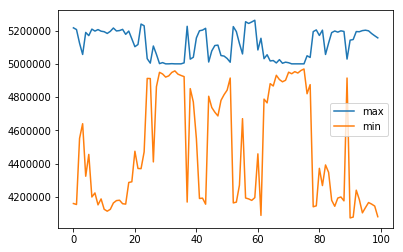

In [26]:
asset_plot(record)

In [27]:
thres = get_best_thres(record).split('_')
buy_thres, sell_thres = float(thres[0]), float(thres[1])

216457 -839688
123958 -447728
56461 -359831
228860 -529441
31133 -87673
1379 -51001
0 -42378
0 -39920
0 -30921


In [25]:
thres = get_best_thres_by_tr_test(record, test_record, 0.4,0.6).split('_')
buy_thres, sell_thres = float(thres[0]), float(thres[1])
print buy_thres, sell_thres

-150 -1451
-150 -1451
-150 -1451
83598 -6700
102549 -20149
100599 -14600
92349 -6250
82048 -6700
80498 -6700
121646 -10550
2.0 -2.3


In [47]:
thres = get_best_thres(record).split('_')
buy_thres, sell_thres = float(thres[0]), float(thres[1])
print buy_thres, sell_thres

76455 -28196
82405 -28196
83955 -29644
110406 -28944
112478 -30933
109077 -25035
2.3 -2.4


In [51]:
# buy_thres, sell_thres=2.2,-2.4
def test_model(daylst, clf_dic=clf_dic, score_dic=score_dic, load_instance=rese, train_instance=train, trade_instance=trade, 
    tickerlst=tickerlst, target=target, lag=lag, period=period, buy_thres=buy_thres, sell_thres=sell_thres,hold_per_trade=50):
    tmp_data = load_instance.load_data(tickerlst, daylst, lag, period)
    tmp_price = load_instance.load_price(daylst, lag)
    tmp_x, tmp_y = train_instance.split_x_y(tmp_data)
    tmp_predict = easy_ensemble_predict(tmp_x, clf_dic, score_dic)
    corr = np.corrcoef(tmp_predict, tmp_y)[0][-1]
    print 'corr value between predict value and true value is: %f' %corr
    tmp_asset = trade_instance.simu_trade1(tmp_price, tmp_predict,buy_thres, sell_thres,
        hold_per_trade=hold_per_trade)
    plt.figure(figsize= (10,6))
    plt.title('asset track of test data')
    plt.plot(tmp_asset)
    plt.show()

wrong to get fee type from database
enter fee type, per or fixedper
enter your fee value0.000045


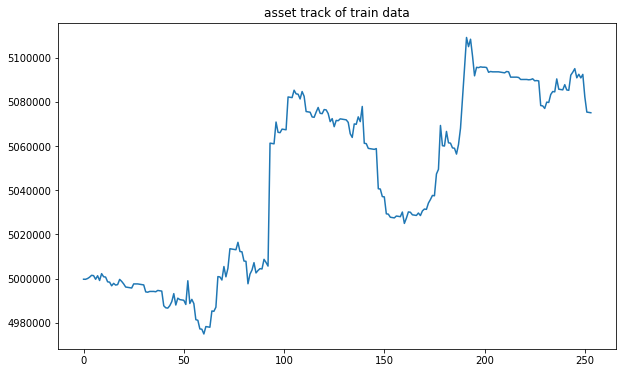

In [71]:
asset = trade.simu_trade1(train_price, train_predict, buy_threshold=buy_thres,sell_threshold=sell_thres
                                  , hold_per_trade=50)
plt.figure(figsize= (10,6))
plt.title('asset track of train data')
plt.plot(asset)
plt.show()

wrong to get fee type from database
enter fee type, per or fixedper
enter your fee value0.000045


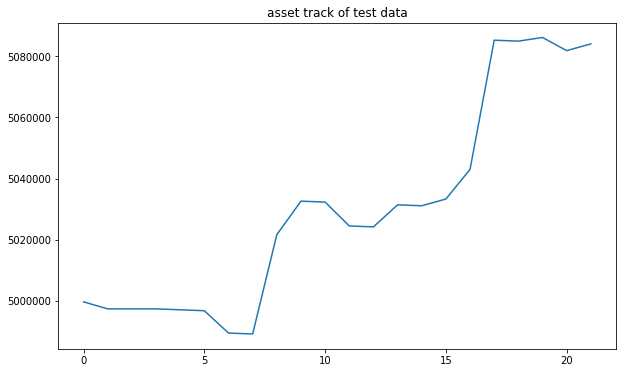

In [60]:
test_price_df = rese.load_price(test_daylst,period)
test_asset = trade.simu_trade1(test_price_df, test_pred, buy_threshold=buy_thres,sell_threshold=sell_thres
                                  , hold_per_trade=100)
plt.figure(figsize= (10,6))
plt.plot(test_asset)
plt.title('asset track of test data')
plt.show()

----------------------------Simulate Trade-----------------------

corr value between predict value and true value is: 0.078965
wrong to get fee type from database
enter fee type, per or fixedper
enter your fee value0.000045


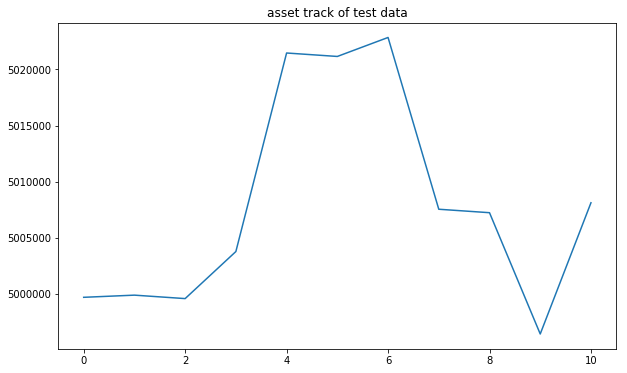

In [64]:
valid_daylst=rese.generate_daylst('20180315', '20180315')
test_model(valid_daylst,hold_per_trade=100)

corr value between predict value and true value is: 0.093355
wrong to get fee type from database
enter fee type, per or fixedper
enter your fee value0.000045


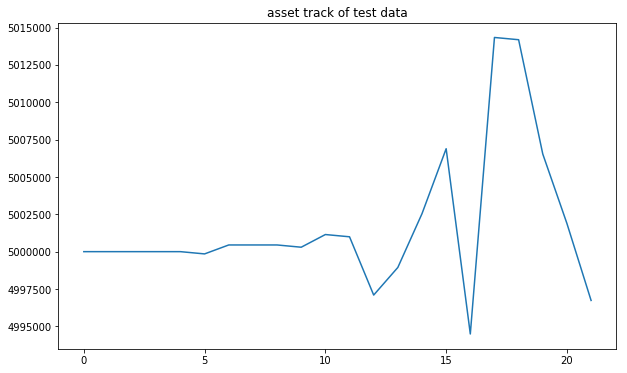

In [69]:
valid_daylst=rese.generate_daylst('20180410', '20180410')
test_model(valid_daylst,hold_per_trade=50)

In [ ]:
thres = get_best_thres_by_tr_test(record, test_record, train_weig=0.4, test_weig=0.6).split('_')
buy_thres, sell_thres = float(thres[0]), float(thres[1])
print 'buy_thres: %f, sell_thres: %f' %(buy_thres, sell_thres)

In [ ]:
asset = trade.simu_trade1(train_price, train_predict, buy_threshold=buy_thres,sell_threshold=sell_thres
                                  , hold_per_trade=50)
plt.figure(figsize= (10,6))
plt.title('asset track of train data')
plt.plot(asset)
plt.show()

In [ ]:
test_price_df = rese.load_price(test_daylst,period)
test_asset = trade.simu_trade1(test_price_df, test_pred, buy_threshold=buy_thres,sell_threshold=sell_thres
                                  , hold_per_trade=50)
plt.figure(figsize= (10,6))
plt.plot(test_asset)
plt.title('asset track of test data')
plt.show()

In [ ]:
model_name = 'ridge'
to_save_dir = '/media/charles/charles_13162398828/hdd/output/trade_asset/'+model_name+'/cut_outliered/'
if not os.path.exists(to_save_dir):
    os.makedirs(to_save_dir)
record = {}
for buy_thres in np.arange(1,3,0.1):
    for sell_thres in np.arange(-1,-2,-0.1):
        pair = str(buy_thres)+'_'+str(sell_thres)
        asset = trade.simu_trade1(price_df, train_predict, buy_threshold=buy_thres,sell_threshold=sell_thres
                                  , hold_per_trade=5)
        record[pair] = (max(asset), min(asset))
        plt.figure(figsize= (12,8))
        plt.plot(asset)
        plt.savefig(to_save_dir+pair+'.jpg')
        plt.close()

In [73]:
from sklearn import ensemble

In [83]:
clf_1 = ensemble.GradientBoostingRegressor(n_estimators=100,max_depth=50)
clf_1.fit(train_x, train_y)
clf_1.score(train_x, train_y)

0.0

0.01841438425390074